# Анализ данных и прогнозирование риска развития диабета.

## Решение задачи бинарной классификации

Система наблюдения за поведенческими факторами риска (BRFSS) представляет собой телефонный опрос, посвящённый здоровью, который ежегодно собирается CDC. Ежегодно в рамках опроса собираются ответы более 400 000 американцев о рискованном для здоровья поведении, хронических заболеваниях и использовании профилактических услуг. Он проводится каждый год с 1984 года. Для этого проекта используется CSV-файл набора данных за 2015 год. В нём содержатся ответы от 253 680 человек и 21 признак. Эти признаки представляют собой либо вопросы, непосредственно заданные участникам, либо расчетные переменные, основанные на индивидуальных ответах участников. Сами признаки таковы:<br>
1) HighBP - имеется ли повышенное давление<br>
2) HighChol - имеется ли повышенный холестерин<br>
3) CholCheck - проверялся ли холестерин за последние 5 лет<br>
4) BMI - индекс массы тела<br>
5) Smoker - было ли выкурено не менее 100 сигарет за всю жизнь<br>
6) Stroke - был ли инсульт<br>
7) HeartDiseaseorAttack - наличие ишемической болезни сердца (ИБС) или инфаркта миокарда (ИМ)<br>
8) PhysActivity - была ли физическая активность (не включая рабочие процессы) за последние 30 дней<br>
9) Fruits - употребляет ли фрукты 1 раз и более каждый день<br>
10) Veggies - употребляет ли овощи 1 раз и более каждый день<br>
11) HvyAlcoholConsump - употребление алкоголя не менее 14 раз за неделю (для мужчин) и не менее 7 раз за неделю (для женщин)<br>
12) AnyHealthcare - наличие медицинской страховки<br>
13) NoDocbcCost - наличие случаев за последние 12 месяцев, когда нужно было обратиться к врачу, но не было возможности ввиду стоимости<br>
14) GenHlth - можете ли Вы сказать, что Ваше здоровье в общем: 1 - отличное, 2 - очень хорошее, 3 - хорошее, 4 - удовлетворительное, 5 - плохое<br>
15) MentHlth - количество дней от 1 до 30, когда ментальное здоровье (подавленное состояние, депрессия) было плохим<br>
16) PhysHlth - количество дней от 1 до 30, когда физическое здоровье (травмы, физическое состояние и т.д.) было плохим<br>
17) DiffWalk - серьёзные трудности при ходьбе по ровной дороге или по лестнице<br>
18) Sex - пол (1 - мужчина, 0 - женщина)<br>
19) Age - тринадцатиуровневая возрастная мера (1 = 18-24, 9 = 60-64, 13 = 80+ и т.п., см. _AGEG5YR codebook)<br>
20) Education - уровень образования (1 = никогда не посещал школу или посещал только детский сад, 2 = 1-8 классы и т.п., см. EDUCA codebook)<br>
21) Income - уровень дохода (1 = менее 10.000$, 8 = 75.000$ и более, см. INCOME2 codebook)

В первую очередь загрузим в проект модули, функционал которых нам понадобится в дальнейшем.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, PowerTransformer
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN
from imblearn.combine import SMOTEENN
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import optuna
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Модуль numpy нам предоставляет качественные многомерные массивы, модуль pandas предоставляет серии и датафреймы, в которых удобно хранить данные. Модуль sklearn (scikit-learn) предоставляет нам объёмный функционал для анализа и обработки данных, а также множество моделей для решения задачи бинарной классификации. Модуль imblearn предоставляет нам функционал для работы с несбалансированными классами. Модули xgboost, lightgbm, catboost - передовые фреймворки, реализующие градиентный бустинг над решающими деревьями. Модуль optuna позволяет удобно подбирать оптимальные гиперпараметры в модели. Модули matplotlib и seaborn - популярные фреймворки для визуализации данных. Модуль warnings позволяет отключить всплывающие уведомления.

# Предварительная обработка данных

Выгрузим наши данные и взглянём на них

In [2]:
data = pd.read_csv("C:\diabets\diabetes_binary_health_indicators_BRFSS2015.csv")
print('len of data ', len(data))
data.info()
print('len of missing values ', data.isna().sum().sum())
print('len of duplicated data ', data.duplicated().sum())
data = data.drop_duplicates().reset_index(drop=True)
print('len of data after deleting duplicates ', len(data))

len of data  253680
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non

Суммарно мы имеем 253680 объектов и 22 признака: первый признак - наша цель, указывающая на наличие диабета (0 - отсутствие диабета, 1 - присутствие диабета). Все признаки имеют тип данных float64, отсутствуют пропущенные значения, но присутствуют 24206 дубликатов. После удаления дубликатов осталось 229474 объектов.
    

Выполним проверку данных на выбросы

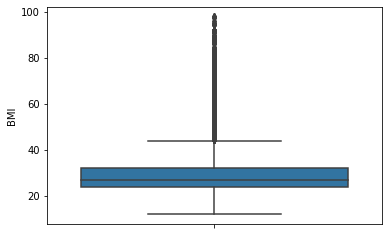

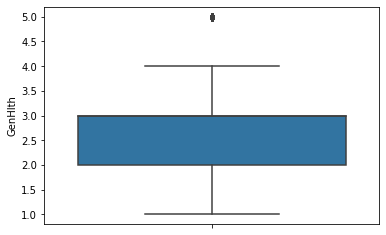

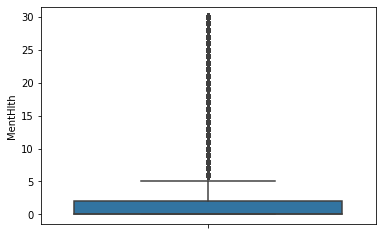

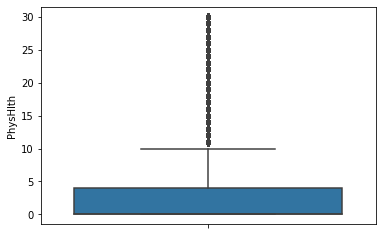

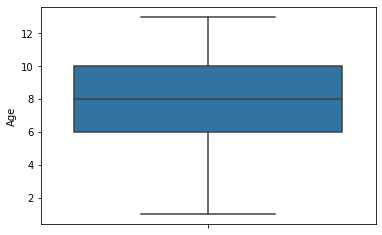

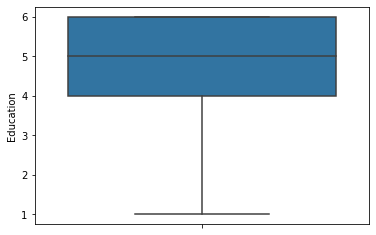

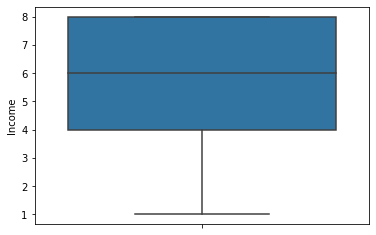

In [3]:
fig = plt.figure()      # No outliers
sns.boxplot(data=data, y='BMI')
plt.xticks(fontsize=5)
plt.show()

fig = plt.figure()      # No outliers
sns.boxplot(data=data, y='GenHlth')
plt.xticks(fontsize=5)
plt.show()

fig = plt.figure()      # No outliers
sns.boxplot(data=data, y='MentHlth')
plt.xticks(fontsize=5)
plt.show()

fig = plt.figure()      # No outliers
sns.boxplot(data=data, y='PhysHlth')
plt.xticks(fontsize=5)
plt.show()

fig = plt.figure()      # No outliers
sns.boxplot(data=data, y='Age')
plt.xticks(fontsize=5)
plt.show()

fig = plt.figure()      # No outliers
sns.boxplot(data=data, y='Education')
plt.xticks(fontsize=5)
plt.show()

fig = plt.figure()      # No outliers
sns.boxplot(data=data, y='Income')
plt.xticks(fontsize=5)
plt.show()

In [4]:
print(data['HighBP'].value_counts())
print(data['HighChol'].value_counts())
print(data['CholCheck'].value_counts())
print(data['Smoker'].value_counts())
print(data['Stroke'].value_counts())
print(data['HeartDiseaseorAttack'].value_counts())
print(data['PhysActivity'].value_counts())
print(data['Fruits'].value_counts())
print(data['Veggies'].value_counts())
print(data['HvyAlcoholConsump'].value_counts())
print(data['AnyHealthcare'].value_counts())
print(data['NoDocbcCost'].value_counts())
print(data['DiffWalk'].value_counts())
print(data['Sex'].value_counts())
print(data['Diabetes_binary'].value_counts())

HighBP
0.0    125214
1.0    104260
Name: count, dtype: int64
HighChol
0.0    128129
1.0    101345
Name: count, dtype: int64
CholCheck
1.0    220176
0.0      9298
Name: count, dtype: int64
Smoker
0.0    122585
1.0    106889
Name: count, dtype: int64
Stroke
0.0    219190
1.0     10284
Name: count, dtype: int64
HeartDiseaseorAttack
0.0    205761
1.0     23713
Name: count, dtype: int64
PhysActivity
1.0    168214
0.0     61260
Name: count, dtype: int64
Fruits
1.0    140593
0.0     88881
Name: count, dtype: int64
Veggies
1.0    182337
0.0     47137
Name: count, dtype: int64
HvyAlcoholConsump
0.0    215524
1.0     13950
Name: count, dtype: int64
AnyHealthcare
1.0    217085
0.0     12389
Name: count, dtype: int64
NoDocbcCost
0.0    208151
1.0     21323
Name: count, dtype: int64
DiffWalk
0.0    186849
1.0     42625
Name: count, dtype: int64
Sex
0.0    128715
1.0    100759
Name: count, dtype: int64
Diabetes_binary
0.0    194377
1.0     35097
Name: count, dtype: int64


Выбросы отсутствуют. Тем не менее, применим LocalOutlierFactor* для удаления данных, сильно отличающихся от других. Такие данные могут быть потенциальными выбросами.
*LocalOutlierFactor - эффекитвный алгоритм выявления выбросов на основе ближайших соседей. Данный алгоримт сравнивает локальную плостность каждого объекта с локальной плотностью его k ближайших соседей, и объекты с существенно низкой плотностью признаются выбросами.

In [5]:
outlier_detector = LocalOutlierFactor()
X = data.iloc[:, 1:]
Y = data['Diabetes_binary']
t = outlier_detector.fit_predict(X)
print()
for i in range(len(t)):
    if t[i] == -1:
        t[i] = False
    else:
        t[i] = True
t = t.astype(bool)
X = X.iloc[t, :]
Y = Y.iloc[t]
X.reset_index(drop=True, inplace=True)
Y.reset_index(drop=True, inplace=True)
print('len of data after deleting outliers ', len(X))


len of data after deleting outliers  229422


В результате было удалено 52 (0.02%) объекта, подозрительно сильно отличающихся от других.

# Исследовательский анализ данных (EDA)

Взглянём на распредение целевого признака.

Diabetes_binary
0.0    194337
1.0     35085
Name: count, dtype: int64
Diabetes_binary
0.0    84.707221%
1.0    15.292779%
Name: proportion, dtype: object


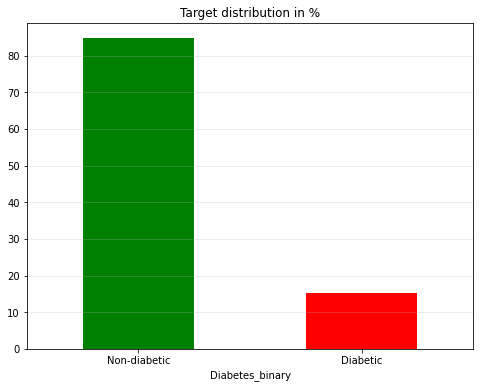

In [6]:
print(Y.value_counts())
print(Y.value_counts(normalize = True).apply(lambda x: format(x, '%')))
(Y.value_counts(normalize = True)*100).plot(kind='bar', figsize=(8, 6), color=['green', 'red'])
plt.title('Target distribution in %')
plt.xticks(ticks=[0, 1], labels=['Non-diabetic', 'Diabetic'], rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

Видим, что классы несбалансированные: только 15% людей из представленных данных имеют диабет.

Проанализируем бинарные признаки.

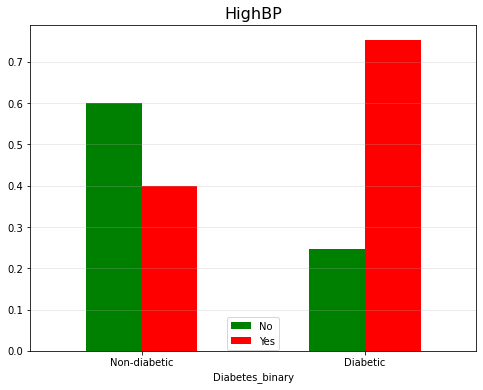

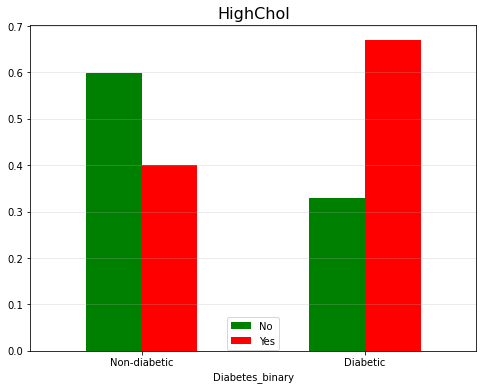

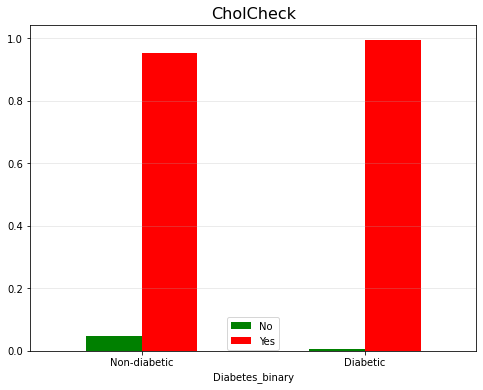

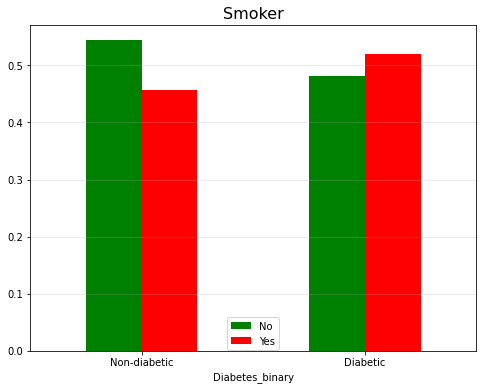

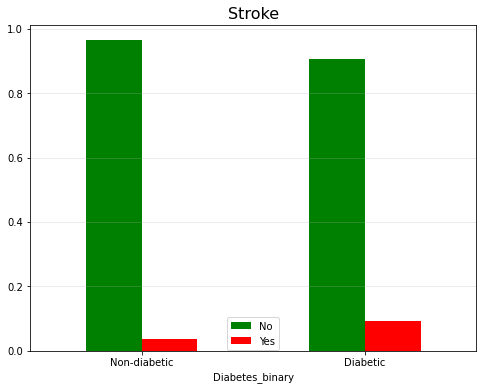

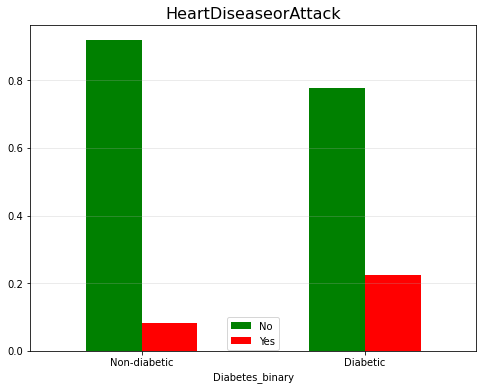

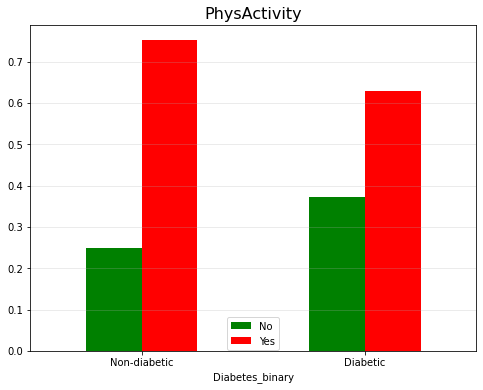

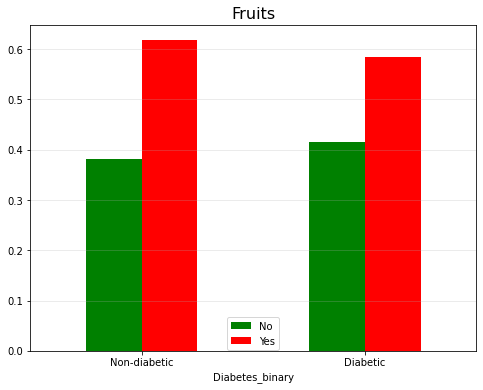

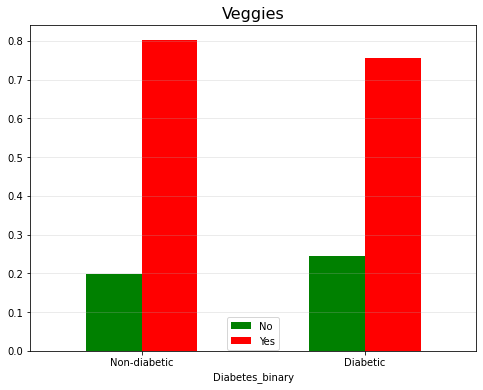

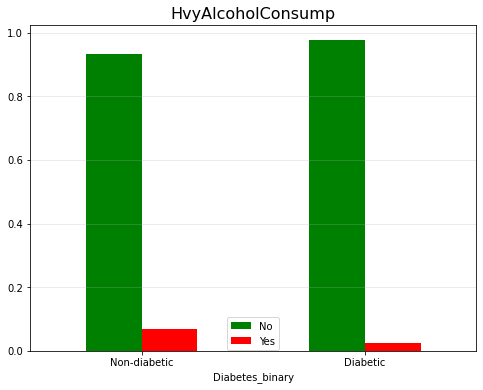

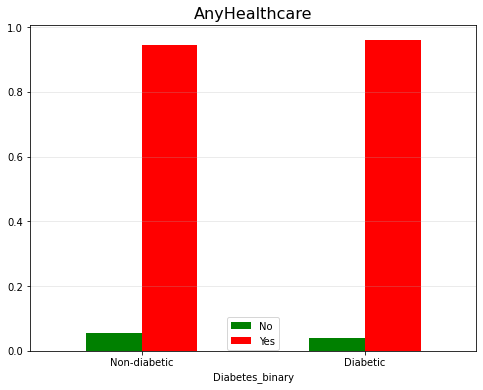

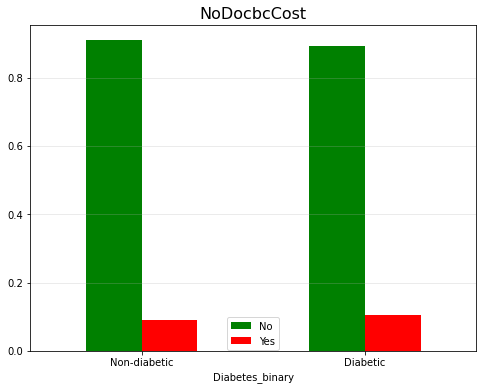

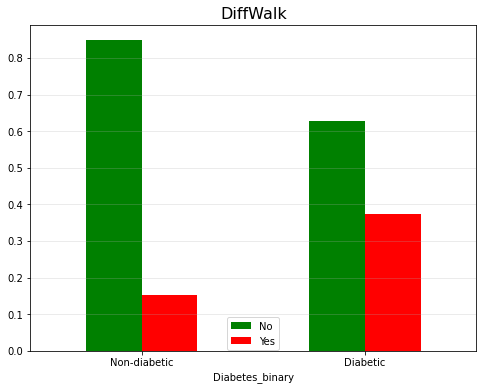

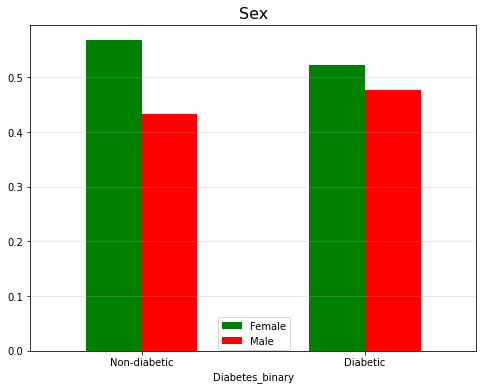

In [7]:
binary_features = X.loc[:, (X.nunique() == 2).values].columns
bin_table_without_y = X[binary_features]
bin_table_with_y = pd.concat([Y, bin_table_without_y], axis=1)
for feat in binary_features:
    bin_table_with_y.groupby('Diabetes_binary')[feat].value_counts(normalize=True).unstack().plot(kind='bar', figsize=(8, 6), color=['green', 'red'])
    plt.xticks(ticks=[0, 1], labels=['Non-diabetic', 'Diabetic'], rotation=0)
    if feat != 'Sex':
        plt.legend(['No', 'Yes'], bbox_to_anchor=(0.43, 0.118, 0, 0))
    else:
        plt.legend(['Female', 'Male'], bbox_to_anchor=(0.41, 0.118, 0, 0))
    plt.title(feat, fontsize=16)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

1) Высокое давление: диабетики часто страдают от повышенного давления, у них оно почти в 2 раза чаще наблюдается, чем у недиабетиков.<br>
2) Высокий холестерин: диабетики часто страдают от повышенного холестерина, у них он более чем в 1.5 раза чаще наблюдается, чем у недиабетиков.<br>
3) Проверка холестерина в последние 5 лет: существенной разницы между двумя группами не наблюдается, в обеих группах большое число людей, проверявших холестерин в последние 5 лет.<br>
4) Курение (минимум 100 сигарет за всю жизнь): немного больше половины диабетиков - курильщики, в то время как среди недиабетчиков их доля немного меньше половины. В целом же существенной связи между курением и диабетом не наблюдается.<br>
5) Перенесённый инсульт: в целом доля диабетчиков, перенёсших инсульт, мала (около 10%). Среди недиабетиков доля людей, перенёсших инсульт, примерно в 2 раза меньше.<br>
6) Ишемическая болезнь сердца (ИБС) или инфаркт миокарда (ИМ): среди диабетчиков данные заболевания встречаются более чем в 2 раза чаще, чем среди недиабетчиков.<br>
7) Физическая активность в последние 30 дней (без учёта рабочей деятельности): у физически активных людей меньше риск развития диабета.<br>
8) Употребление фруктов 1 или более раз в день: существенной разницы между двумя группами не наблюдается, хотя по имеющимся данным риск развития диабета у людей, употребляющих фрукты, немного ниже.<br>
9) Употребление овощей 1 или более раз в день: существенной разницы между двумя группами не наблюдается, хотя по имеющимся данным риск развития диабета у людей, употребляющих овощи, немного ниже.<br>
10) Частое употребление алкоголя: существенной разницы между двумя группами не наблюдается, хотя интересно, что по имеющимся данным люди, часто употребляющие алкоголь, менее подвержены диабету, чем люди, его не употребляющие.<br>
11) Наличие медицинской страховки: существенной разницы между двумя группами не наблюдается.<br>
12) Невозможность обратиться к доктору из-за цены в последние 12 месяцев: существенной разницы между двумя группами не наблюдается.<br>
13) Существенные трудности при ходьбе или подъёме по лестнице: среди диабетиков почти в 2.5 раза больше людей, чем среди недиабетиков, испытывают трудности.<br>
14) Пол: существенной разницы между двумя группами не наблюдается.

Рассмотрим распределение данных по значениям небинарных признаков.

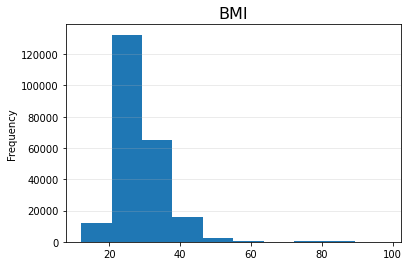

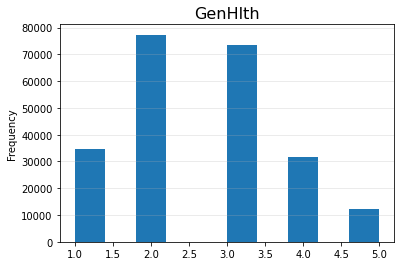

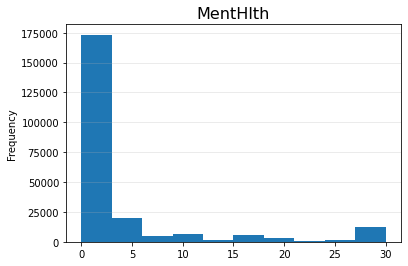

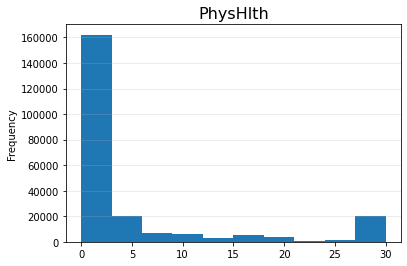

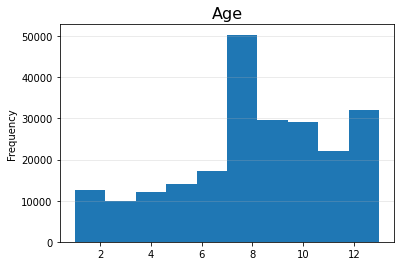

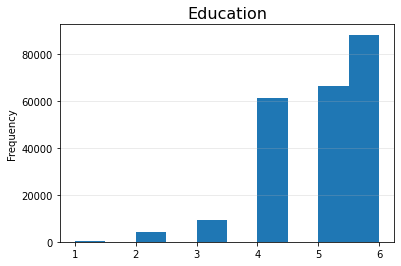

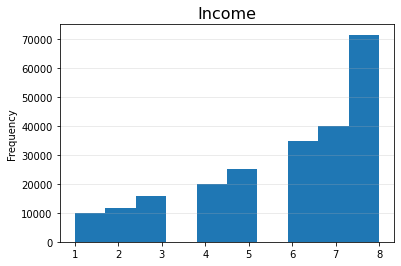

In [8]:
nonbinary_features = (X.loc[:, (X.nunique() > 2).values].columns)
nonbin_table_without_y= X[nonbinary_features]
for feat in nonbinary_features:
    nonbin_table_without_y[feat].plot(kind='hist')
    plt.grid(axis='y', alpha=0.3)
    plt.title(feat, fontsize=16)
    plt.show()

Рассмотрим кардинальность каждого небинарного признака.

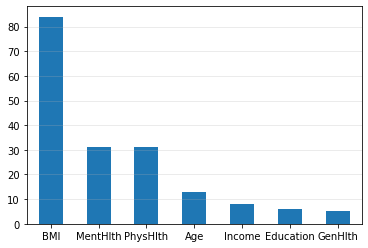

In [9]:
nonbin_table_without_y.nunique().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

Построим корреляционную матрицу признаков.

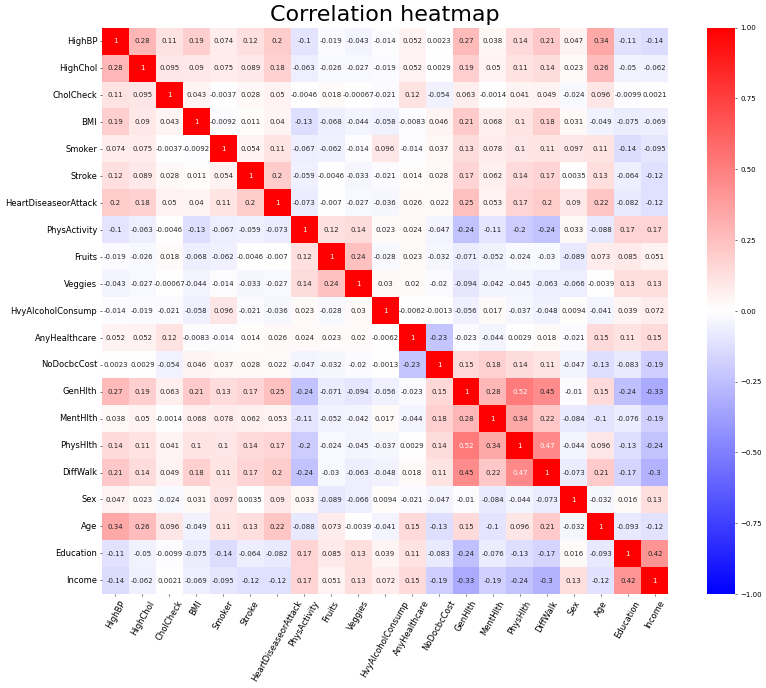

In [10]:
colormap = mpl.colors.LinearSegmentedColormap.from_list('colormap', ['blue', 'white', 'red'])
fig, ax = plt.subplots(figsize=(20, 15), dpi = 50)
heatmap = sns.heatmap(X.corr(), cmap=colormap, annot=True, cbar=True, vmin=-1, vmax=1, center=0, square=True)
heatmap.set_title('Correlation heatmap', fontsize=32, pad=10)
ax.tick_params(labelsize=12)
plt.xticks(rotation=60)
plt.show()

По матрице видно, что некоторые признаки частично коррелируют, наибольшую корреляцию имеют признаки: общее здоровье и физическое здоровье, трудности при ходьбе и общее здоровье, трудности при ходьбе и физическое здоровье, образование и доход.

Построим диаграмму, на которой отразим корреляцию признака и цели.

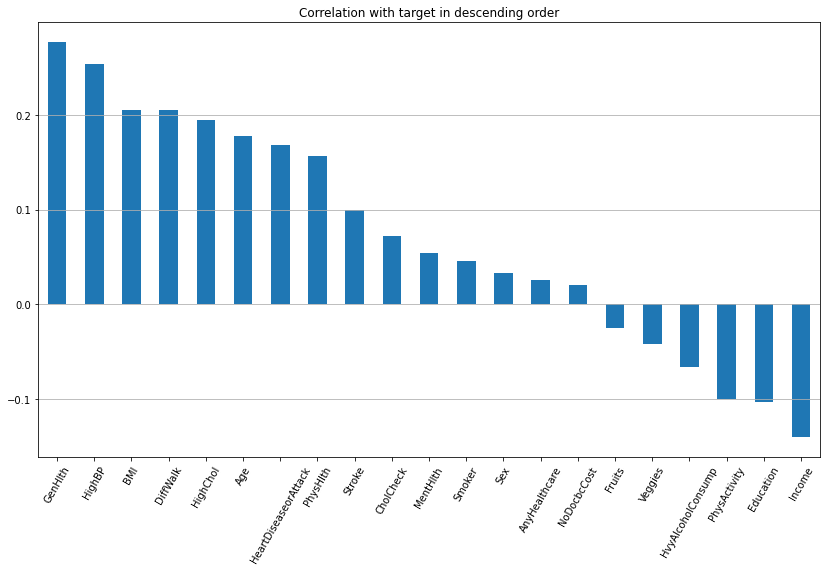

In [11]:
X.corrwith(Y).sort_values(ascending=False).plot(kind='bar', figsize=(14, 8))
plt.title('Correlation with target in descending order')
plt.xticks(rotation=60, size=10)
plt.grid(axis='y')
plt.show()

Проанализируем небинарные признаки.

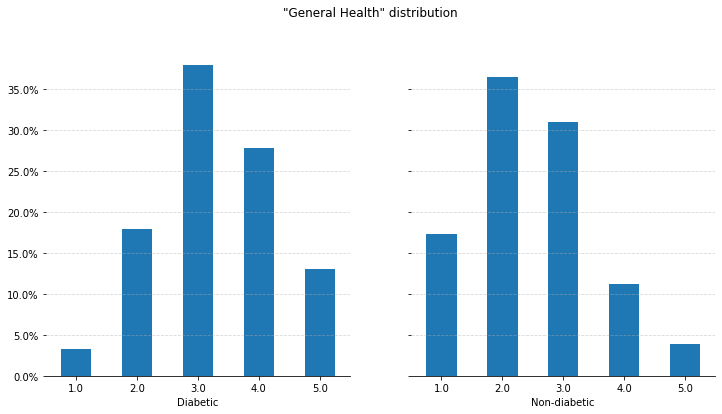

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharey='row')
fig.suptitle("\"General Health\" distribution")

X.iloc[Y[Y==1].index.tolist()]['GenHlth'].value_counts(normalize=True).sort_index().plot(ax=ax1, kind='bar')
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.grid(axis='y', alpha=0.5, ls='--')
ax1.set_xlabel('Diabetic')
ax1.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0)

X.iloc[Y[Y==0].index.tolist()]['GenHlth'].value_counts(normalize=True).sort_index().plot(ax=ax2, kind='bar')
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.grid(axis='y', alpha=0.5, ls='--')
ax2.set_xlabel('Non-diabetic')
ax2.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0)
plt.show()


По диаграммам видно, что в среднем диабетики оценивают своё общее здоровье заметно хуже, чем недиабетики.

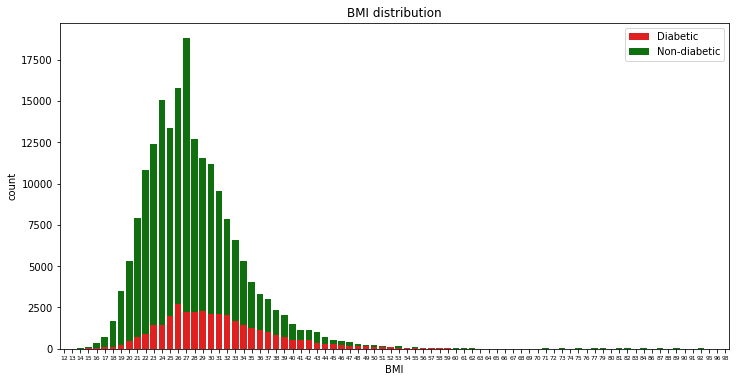

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(x=X.iloc[Y[Y==1].index.tolist()]['BMI'].astype('uint8'), color='red', label='Diabetic', zorder=2)
sns.countplot(x=X.iloc[Y[Y==0].index.tolist()]['BMI'].astype('uint8'), color='green', label='Non-diabetic', zorder=1)
ax.tick_params(axis='x', labelsize=6)
plt.title('BMI distribution')
plt.legend()
plt.show()

И́ндекс ма́ссы те́ла (ИМТ, англ. body mass index (BMI)) — величина, позволяющая оценить степень соответствия массы человека и его роста и тем самым косвенно судить о том, является ли масса недостаточной, нормальной или избыточной. Важен при определении показаний для необходимости лечения.
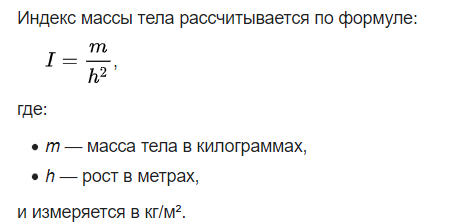

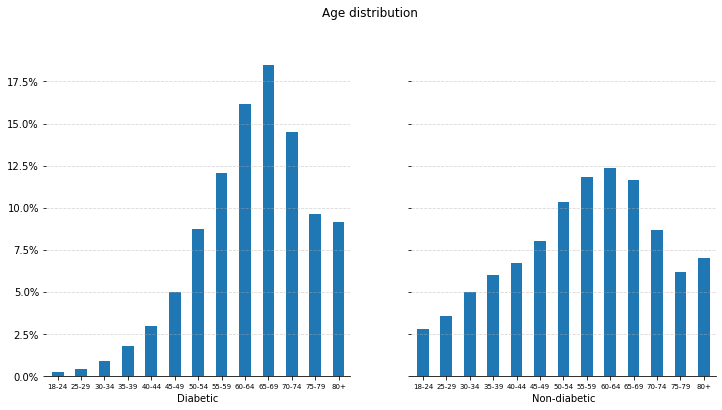

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharey='row')
fig.suptitle("Age distribution")

X.iloc[Y[Y==1].index.tolist()]['Age'].value_counts(normalize=True).sort_index().plot(ax=ax1, kind='bar')
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.grid(axis='y', alpha=0.5, ls='--')
ax1.set_xlabel('Diabetic')
ax1.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0)
ax1.set_xticklabels(['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+'])
ax1.tick_params(axis='x', labelsize=7)


X.iloc[Y[Y==0].index.tolist()]['Age'].value_counts(normalize=True).sort_index().plot(ax=ax2, kind='bar')
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.grid(axis='y', alpha=0.5, ls='--')
ax2.set_xlabel('Non-diabetic')
ax2.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0)
ax2.set_xticklabels(['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+'])
ax2.tick_params(axis='x', labelsize=7)
plt.show()

Из графиков видно, что наиболее уязвимая для диабета возрастная группа - это люди возрастом от 55 до 74 лет.

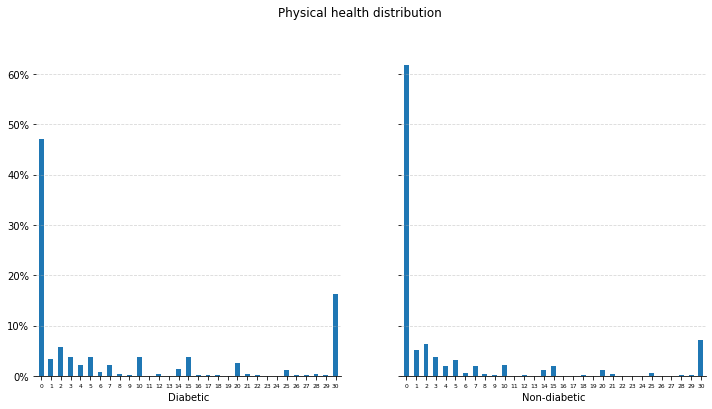

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharey='row')
fig.suptitle("Physical health distribution")

X.iloc[Y[Y==1].index.tolist()]['PhysHlth'].value_counts(normalize=True).sort_index().plot(ax=ax1, kind='bar')
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.grid(axis='y', alpha=0.5, ls='--')
ax1.set_xlabel('Diabetic')
ax1.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0)
ax1.set_xticklabels(np.arange(31))
ax1.tick_params(axis='x', labelsize=6)


X.iloc[Y[Y==0].index.tolist()]['PhysHlth'].value_counts(normalize=True).sort_index().plot(ax=ax2, kind='bar')
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.grid(axis='y', alpha=0.5, ls='--')
ax2.set_xlabel('Non-diabetic')
ax2.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0)
ax2.set_xticklabels(np.arange(31))
ax2.tick_params(axis='x', labelsize=6)
plt.show()

По графикам видно, что среди диабетиков существенно количество людей, указавших, что испытывали проблемы с физическим здоровьем все 30 дней. Среди недиабетиков процент таких людей ниже, однако количество самих недиабетиков значительно выше.

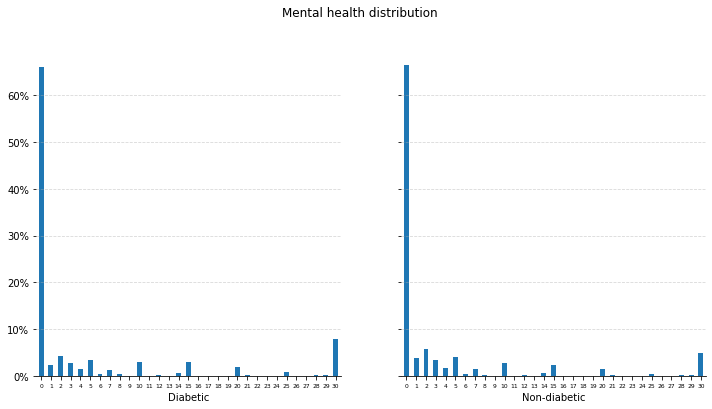

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharey='row')
fig.suptitle("Mental health distribution")

X.iloc[Y[Y==1].index.tolist()]['MentHlth'].value_counts(normalize=True).sort_index().plot(ax=ax1, kind='bar')
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.grid(axis='y', alpha=0.5, ls='--')
ax1.set_xlabel('Diabetic')
ax1.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0)
ax1.set_xticklabels(np.arange(31))
ax1.tick_params(axis='x', labelsize=6)


X.iloc[Y[Y==0].index.tolist()]['MentHlth'].value_counts(normalize=True).sort_index().plot(ax=ax2, kind='bar')
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.grid(axis='y', alpha=0.5, ls='--')
ax2.set_xlabel('Non-diabetic')
ax2.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0)
ax2.set_xticklabels(np.arange(31))
ax2.tick_params(axis='x', labelsize=6)
plt.show()

В случае ментального здоровья картина по группам примерно одинаковая, существенных различий нет, однако среди диабетиков процент людей, указавших, что испытывали проблемы с ментальным здоровьем все 30 дней, немного выше, чем среди недиабетиков.

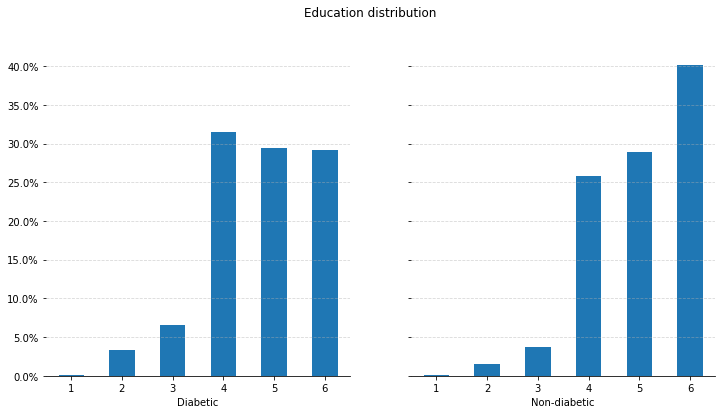

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharey='row')
fig.suptitle("Education distribution")

X.iloc[Y[Y==1].index.tolist()]['Education'].value_counts(normalize=True).sort_index().plot(ax=ax1, kind='bar')
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.grid(axis='y', alpha=0.5, ls='--')
ax1.set_xlabel('Diabetic')
ax1.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0)
ax1.set_xticklabels([1, 2, 3, 4, 5, 6])
ax1.tick_params(axis='x', labelsize=10)


X.iloc[Y[Y==0].index.tolist()]['Education'].value_counts(normalize=True).sort_index().plot(ax=ax2, kind='bar')
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.grid(axis='y', alpha=0.5, ls='--')
ax2.set_xlabel('Non-diabetic')
ax2.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0)
ax2.set_xticklabels([1, 2, 3, 4, 5, 6])
ax2.tick_params(axis='x', labelsize=10)
plt.show()

Среди диабетиков замечен сдвиг в сторону меньшей образованности, откуда может следовать незнание профилактических мер, направленных на уменьшение риска возникновения диабета, а также мер предосторожности.

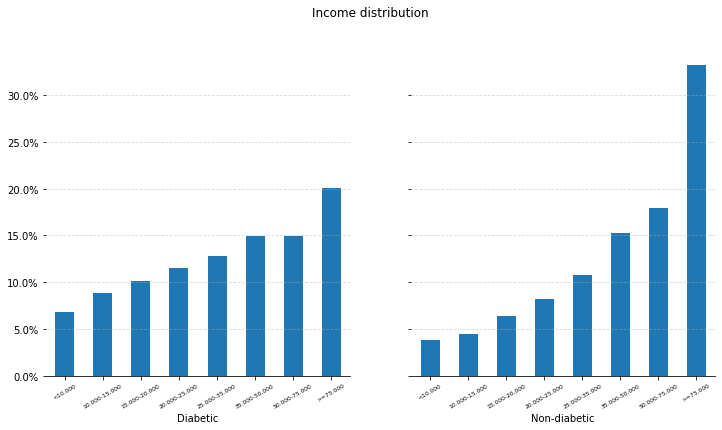

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharey='row')
fig.suptitle("Income distribution")

X.iloc[Y[Y==1].index.tolist()]['Income'].value_counts(normalize=True).sort_index().plot(ax=ax1, kind='bar')
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.grid(axis='y', alpha=0.5, ls='--')
ax1.set_xlabel('Diabetic')
ax1.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=30)
ax1.set_xticklabels(['<10.000', '10.000-15.000', '15.000-20.000', '20.000-25.000', '25.000-35.000', '35.000-50.000', '50.000-75.000', '>=75.000'])
ax1.tick_params(axis='x', labelsize=6)


X.iloc[Y[Y==0].index.tolist()]['Income'].value_counts(normalize=True).sort_index().plot(ax=ax2, kind='bar')
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.grid(axis='y', alpha=0.5, ls='--')
ax2.set_xlabel('Non-diabetic')
ax2.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=30)
ax2.set_xticklabels(['<10.000', '10.000-15.000', '15.000-20.000', '20.000-25.000', '25.000-35.000', '35.000-50.000', '50.000-75.000', '>=75.000'])
ax2.tick_params(axis='x', labelsize=6)
plt.show()

Из графиков видно, что доход среди диабетиков в среднем ниже, чем среди недиабетиков, откуда может следовать невозможность приобретения средств, помогающих предостеречься от диабета, в том числе невозможность иметь качественное медицинское обслуживание.

# Анализ и отбор признаков

В первую очередь взглянём на коэффициент корреляции Пирсона каждого признака с целью. Оставим только те признаки, коэффициент корреляции которых выше 0.09.

In [19]:
pearson_corr = X.corrwith(Y).abs().sort_values(ascending=False)
print('Pearson correlation\n', pearson_corr[pearson_corr > 0.09])

Pearson correlation
 GenHlth                 0.276983
HighBP                  0.254308
BMI                     0.205385
DiffWalk                0.205283
HighChol                0.194940
Age                     0.177317
HeartDiseaseorAttack    0.168164
PhysHlth                0.156258
Income                  0.140729
Education               0.102791
PhysActivity            0.100402
Stroke                  0.099081
dtype: float64


Заметим, что признаки неотрицательные и категориальные (ИМТ приведём к категориальному), а значит - можем воспользоваться тестом хи-квадрат.

In [20]:
X_binned = X.copy()
X_binned['BMI'] = pd.cut(X_binned['BMI'], [0, 18.4, 24.9, 29.9, 34.9, 39.9, float('inf')], labels=[1, 2, 3, 4, 5, 6]).astype('uint8')
chi2_test = chi2(X_binned, Y)
chi2_test_result = pd.DataFrame(chi2_test).T.set_index(X_binned.columns).rename(columns={0: 'Chi2_stats', 1: 'p_value'}).sort_values(by='Chi2_stats', ascending=False)
print(chi2_test_result)

                        Chi2_stats        p_value
PhysHlth              98027.096188   0.000000e+00
MentHlth              11430.364137   0.000000e+00
Age                    8541.430260   0.000000e+00
HighBP                 8095.748050   0.000000e+00
DiffWalk               7872.505745   0.000000e+00
GenHlth                7671.784476   0.000000e+00
HeartDiseaseorAttack   5817.500530   0.000000e+00
HighChol               4868.064068   0.000000e+00
BMI                    4372.562978   0.000000e+00
Income                 3379.782866   0.000000e+00
Stroke                 2151.358803   0.000000e+00
HvyAlcoholConsump       936.369976  1.217859e-205
PhysActivity            617.354255  2.813190e-136
Education               479.458284  2.802980e-106
Smoker                  254.153343   3.228514e-57
Sex                     137.671096   8.600442e-32
NoDocbcCost              83.267010   7.168603e-20
Veggies                  82.090464   1.299983e-19
Fruits                   54.742437   1.374070e-13


Уровень статистической значимости возьмём 0.05, тогда все признаки противоречат нулевой гипотезе, т.е. все признаки существенны.

Следующим шагом выполним тест на основе взаимной информации. Тест на основе взаимной информации позволяет определить величину как линейной, так и нелинейной зависимости двух случайных величин (в отличие от корреляции Пирсона, которая улавливает только линейную зависимость). Для теста требуется, чтобы признаки были категориальные, либо дискретные.

In [21]:
X_binned = X.copy()
X_binned['BMI'] = pd.cut(X_binned['BMI'], [0, 18.4, 24.9, 29.9, 34.9, 39.9, float('inf')], labels=[1, 2, 3, 4, 5, 6]).astype('uint8')
mutual_info = mutual_info_classif(X_binned, Y, discrete_features=True)
mi_result = pd.DataFrame(mutual_info, columns=['MI_value'], index=X.columns).sort_values(by='MI_value', ascending=False)
print(mi_result)

                      MI_value
GenHlth               0.039289
HighBP                0.033098
BMI                   0.023005
Age                   0.021292
HighChol              0.019015
DiffWalk              0.018196
HeartDiseaseorAttack  0.011637
PhysHlth              0.011617
Income                0.009841
Education             0.005202
PhysActivity          0.004767
Stroke                0.004013
CholCheck             0.003760
HvyAlcoholConsump     0.002687
MentHlth              0.002369
Smoker                0.001034
Veggies               0.000840
Sex                   0.000533
AnyHealthcare         0.000350
Fruits                0.000306
NoDocbcCost           0.000193


Выполним дисперсионный анализ (ANOVA) для непрерывных признаков (в нашем случае - только ИМТ). Дисперсионный анализ требует непрерывности случайной величины, её подчинённость нормальному или почти нормальному распределению и равенство дисперсий в группах. Приведём признак к нормальному распределению с одинаковой дисперсией по группам и выполним тест.

In [22]:
continious_column = X['BMI'].copy().to_frame(name='BMI')
transform_to_normal = PowerTransformer(method='box-cox', standardize=True)
continious_column = transform_to_normal.fit_transform(continious_column)
anova = f_classif(continious_column, Y)
anova_result = pd.DataFrame(anova).T.rename(columns={0: 'F_stats', 1: 'p_value'}, index={0: 'BMI'}).sort_values(by='F_stats', ascending=False)
print(anova_result, '\n')

          F_stats  p_value
BMI  10997.969395      0.0 



Признак ИМТ существенен.

Далее применим IV&WOE тест, который наиболее оптимален для отбора признаков в бинарной классификации для логистической регрессии, тем не менее данный тест также полезен в совокупности с другими статистическими тестами. Подробное объяснение данного теста находится здесь https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html
Результаты теста (величины IV) можно интерпретировать по данной таблице:
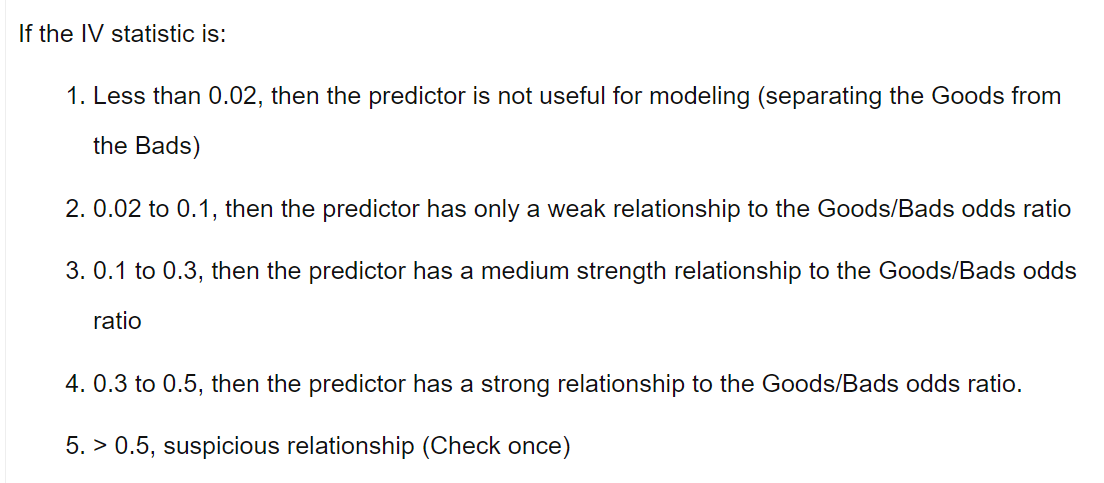

In [22]:
def iv_woe(data, target, bins=10, show_woe=False):
    # Empty Dataframe
    newDF, woeDF = pd.DataFrame(), pd.DataFrame()

    # Extract Column Names
    cols = data.columns

    # Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars])) > 10):
            binned_x = pd.qcut(data[ivars], bins, duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d0 = d0.astype({"x": str})
        d = d0.groupby("x", as_index=False, dropna=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Non-Events'] / d['% of Events'])
        d['IV'] = d['WoE'] * (d['% of Non-Events'] - d['% of Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        temp = pd.DataFrame({"Variable": [ivars], "IV": [d['IV'].sum()]}, columns=["Variable", "IV"])
        newDF = pd.concat([newDF, temp], axis=0)
        woeDF = pd.concat([woeDF, d], axis=0)

        # Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF
iv, woe = iv_woe(pd.concat([Y, X], axis=1), 'Diabetes_binary')
iv.sort_values(by='IV', ascending=False, inplace=True)
iv = iv.set_index('Variable')
print(iv)

                            IV
Variable                      
GenHlth               0.648774
HighBP                0.532794
BMI                   0.391037
Age                   0.369126
HighChol              0.298310
DiffWalk              0.266997
HeartDiseaseorAttack  0.167451
PhysHlth              0.161980
Income                0.151919
Education             0.079232
CholCheck             0.077837
PhysActivity          0.071945
Stroke                0.057394
HvyAlcoholConsump     0.047769
MentHlth              0.024936
Smoker                0.015965
Veggies               0.012761
Sex                   0.008209
AnyHealthcare         0.005618
Fruits                0.004708
NoDocbcCost           0.002937


В конечном итоге я отобрал следующие признаки: общее здоровье, повышенное давление, трудности при ходьбе, ИМТ, повышенный холестерин, возраст, болезни сердца, физическое здоровье, наличие инсульта, образование, доход.<br>
Остальные признаки я сохраню на дальнейшее рассмотрение.

In [23]:
main_features = X[['GenHlth', 'HighBP', 'DiffWalk', 'BMI', 'HighChol', 'Age', 'HeartDiseaseorAttack', 'PhysHlth', 'Stroke', 'Education', 'Income']].columns
additional_features = X[['MentHlth', 'PhysActivity', 'CholCheck', 'HvyAlcoholConsump', 'Smoker', 'Veggies', 'Sex', 'AnyHealthcare', 'Fruits', 'NoDocbcCost']].columns
X_original = X.copy()
Y_original = Y.copy()
X = X[main_features]

# Обучение моделей и отбор лучшей модели для решения задачи прогнозирования риска развития диабета.

Разобьём данные на обучающую выборку и на тестовую выборку, а также выполним предобработку данных.

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
max_abs_scaler = MaxAbsScaler()
max_abs_scaler.fit(X_train)
X_train, X_test = max_abs_scaler.transform(X_train), max_abs_scaler.transform(X_test)

Подсчитаем коэффициент балансировки для положительного класса.

In [25]:
Y_test = Y_test.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)
sum = 0
for i in range(len(Y_train)):
    if Y_train[i] == 1: sum += 1
else: get_sum = sum; print(sum); sum = 0
for i in range(len(Y_test)):
    if Y_test[i] == 1: sum +=1
else: print(sum); sum = 0
balance_value = (len(X_train) - get_sum) / get_sum
print('balance value for class 1 is: ', balance_value)

28171
6914
balance value for class 1 is:  5.5151041851549465


С помощью OPTUNA найдём оптимальные гиперпараметры под модель XGBoost. Я их уже нашёл, однако для включения OPTUNA нужно удалить ''' из кода. Полученные оптимальные гиперпараметры нужно прописать в параметрах модели xgb_params.

In [26]:
dtrain = xgb.DMatrix(X_train, Y_train)
dtest = xgb.DMatrix(X_test, Y_test)
'''def objective_xgboost(trial):
    booster = trial.suggest_categorical('booster', ['gbtree', 'gblinear'])
    max_delta_step = 0
    max_depth = 6
    min_child_weight = 1
    lambda_l2 = 0
    alpha_l1 = 0
    grow_policy = 'depthwise'
    max_leaves = 0
    feature_selector = 'cyclic'
    if booster == 'gbtree':
        max_delta_step = trial.suggest_int('max_delta_step', 0, 10)
        max_depth = trial.suggest_int('max_depth', 6, 16)
        min_child_weight = trial.suggest_int('child_weight', 0, 1000)
        lambda_l2 = trial.suggest_float('lambda_l2', 1e-6, 1e2, log=True)
        alpha_l1 = trial.suggest_float('alpha_l1', 1e-6, 1e2, log=True)
        grow_policy = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
        max_leaves = trial.suggest_int('max_leaves', 50, 2**max_depth - 1)
    if booster == 'gblinear':
        lambda_l2 = trial.suggest_float('lambda_l2', 1e-6, 1e2, log=True)
        alpha_l1 = trial.suggest_float('alpha_l1', 1e-6, 1e2, log=True)
        feature_selector = trial.suggest_categorical('feature_selector', ['cyclic', 'shuffle'])
    xgb_params = {'booster':booster, 'eta':0.01, 'max_delta_step':max_delta_step, 'verbosity': 0, 'max_depth':max_depth, 'tree_method':'hist', 'grow_policy':grow_policy, 'objective':'binary:logistic', 'scale_pos_weight':5.53817936, 'min_child_weight' : min_child_weight, 'lambda' : lambda_l2, 'alpha':alpha_l1, 'max_leaves':max_leaves, 'feature_selector': feature_selector}
    model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=8000, evals=[(dtrain, 'train'), (dtest, 'test')], early_stopping_rounds=50, verbose_eval=False)
    if booster == 'gbtree':
        model_best = model.best_iteration
        model = model[:model_best]
    Y_pred = np.rint(model.predict(dtest))
    res = balanced_accuracy_score(Y_test, Y_pred)
    return res
study = optuna.create_study(direction='maximize')
study.optimize(objective_xgboost, n_trials=1000)'''
xgb_params = {'booster': 'gbtree', 'eta': 0.01, 'max_delta_step': 4, 'verbosity': 1, 'max_depth': 9, 'tree_method': 'hist', 'grow_policy': 'depthwise', 'objective': 'binary:logistic', 'scale_pos_weight': balance_value, 'min_child_weight': 90, 'lambda': 4.149646669854143e-05, 'alpha': 75.12310130246308, 'max_leaves': 102}


С помощью OPTUNA найдём оптимальные гиперпараметры под модель LightGBM. Я их уже нашёл, однако для включения OPTUNA нужно удалить ''' из кода. Полученные оптимальные гиперпараметры нужно прописать в параметрах модели lgb_params.

In [27]:
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_test = lgb.Dataset(X_test, Y_test, reference=lgb_train)
'''def objective_lightjbm(trial):
    max_depth = trial.suggest_int('max_depth', 6, 16)
    num_leaves = trial.suggest_int('num_leaves', 10, 2**max_depth - 1)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 1500)
    extra_trees = trial.suggest_categorical('extra_trees', [True, False])
    max_delta_step = trial.suggest_float('max_delta_step', 0, 15)
    lambda_l1 = trial.suggest_float('lambda_l1', 1e-12, 1e3, log=True)
    lambda_l2 = trial.suggest_float('lambda_l2', 1e-12, 1e3, log=True)
    linear_lambda = trial.suggest_float('linear_lambda', 1e-12, 1e3, log=True)
    min_gain_to_split = trial.suggest_float('min_gain_to_split', 0, 1000)
    path_smooth = trial.suggest_float('path_smooth', 0, 1000)
    lgb_params = {'objective': 'binary', 'feature_pre_filter': False, 'num_iterations':5000, 'learning_rate':0.01, 'num_leaves': num_leaves, 'max_depth':max_depth, 'min_data_in_leaf':min_data_in_leaf, 'extra_trees':extra_trees, 'max_delta_step':max_delta_step, 'lambda_l1':lambda_l1, 'lambda_l2':lambda_l2, 'linear_lambda': linear_lambda, 'min_gain_to_split':min_gain_to_split, 'path_smooth':path_smooth, 'is_unbalance': True, 'verbose': -1}
    model = lgb.train(params=lgb_params, train_set=lgb_train, valid_sets=[lgb_test], valid_names=['test'], verbose_eval=False)
    Y_pred = np.rint(model.predict(X_test))
    res = balanced_accuracy_score(Y_test, Y_pred)
    return res
study = optuna.create_study(direction='maximize')
study.optimize(objective_lightjbm, n_trials=1000)'''
lgb_params = {'objective': 'binary', 'feature_pre_filter': False, 'num_iterations': 5000, 'learning_rate': 0.01, 'num_leaves': 71, 'max_depth': 8, 'min_data_in_leaf': 640, 'extra_trees': True, 'max_delta_step': 6.242619463236953, 'lambda_l1': 1.3580228928921623, 'lambda_l2': 3.1782100321715934e-11, 'linear_lambda': 1.172903692218429e-12, 'min_gain_to_split': 14.735600386681819, 'path_smooth': 47.563791682196154, 'is_unbalance': True, 'verbose': -1}


С помощью OPTUNA найдём оптимальные гиперпараметры под модель CatBoost. Я их уже нашёл, однако для включения OPTUNA нужно удалить ''' из кода.

In [28]:
pooltrain = cb.Pool(X_train, Y_train)
pooltest = cb.Pool(X_test, Y_test)
'''def objective_catboost(trial):
    depth = trial.suggest_int('depth', 6, 16)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-6, 1e3, log=True)
    random_strength = trial.suggest_float('random_strength', 1, 10)
    grow_policy = trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 1000)
    max_leaves = trial.suggest_int('max_leaves', 30, 100)
    auto_class_weights = trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced'])
    if grow_policy == 'Lossguide':
        score_function = 'L2'
    else:
        score_function = 'Cosine'
    CB_classifier = cb.CatBoostClassifier()
    if grow_policy == 'Lossguide':
        CB_classifier.set_params(loss_function='Logloss', eval_metric='BalancedAccuracy', iterations=10000, learning_rate=0.01, l2_leaf_reg=l2_leaf_reg, random_strength=random_strength, use_best_model=True, depth=depth, grow_policy=grow_policy, min_data_in_leaf=min_data_in_leaf, max_leaves=max_leaves, auto_class_weights=auto_class_weights, boost_from_average=True, score_function=score_function, early_stopping_rounds=100, logging_level='Silent')
    else:
        CB_classifier.set_params(loss_function='Logloss', eval_metric='BalancedAccuracy', iterations=10000, learning_rate=0.01, l2_leaf_reg=l2_leaf_reg, random_strength=random_strength, use_best_model=True, depth=depth, grow_policy=grow_policy, min_data_in_leaf=min_data_in_leaf, auto_class_weights=auto_class_weights, boost_from_average=True, score_function=score_function, early_stopping_rounds=100, logging_level='Silent')
    CB_classifier.fit(pooltrain, eval_set=pooltest)
    Y_pred = CB_classifier.predict(pooltest)
    res = balanced_accuracy_score(Y_test, Y_pred)
    return res
study = optuna.create_study(direction='maximize')
study.optimize(objective_catboost, n_trials=1000)'''
pass

С помощью OPTUNA найдём оптимальные гиперпараметры под модель градиентного бустинга из scikit-learn. Я их уже нашёл, однако для включения OPTUNA нужно удалить ''' из кода.

In [29]:
'''def objective_gb(trial):
    opt_max_depth = trial.suggest_int('opt_max_depth', 6, 16)
    opt_max_leaf_nodes = trial.suggest_int('opt_max_leaf_nodes', 50, 2**opt_max_depth - 1)
    opt_min_samples_leaf = trial.suggest_int('opt_min_samples_leaf', 20, 1000)
    opt_l2_reg = trial.suggest_float('opt_l2_reg', 1e-5, 1e0, log=True)
    model = HistGradientBoostingClassifier(learning_rate=0.01, max_iter=5000, max_depth=opt_max_depth, max_leaf_nodes=opt_max_leaf_nodes, min_samples_leaf=opt_min_samples_leaf, l2_regularization=opt_l2_reg, early_stopping=True, scoring='balanced_accuracy', n_iter_no_change=50, class_weight={0:1, 1:6.52466591}, verbose=1)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    res = balanced_accuracy_score(Y_test, Y_pred)
    return res
study = optuna.create_study(direction='maximize')
study.optimize(objective_gb, n_trials=1000)'''
pass

С помощью OPTUNA найдём оптимальные гиперпараметры под модель случайного леса из scikit-learn. Я их уже нашёл, однако для включения OPTUNA нужно удалить ''' из кода.

In [30]:
'''def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 6, 16)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 1000)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 2**max_depth - 1)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    max_samples = trial.suggest_float('max_samples', 0.5, 1)
    model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, max_features=max_features, max_leaf_nodes=max_leaf_nodes, class_weight=class_weight, max_samples=max_samples, verbose=0)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    res = balanced_accuracy_score(Y_test, Y_pred)
    return res
study = optuna.create_study(direction='maximize')
study.optimize(objective_rf, n_trials=1000)'''
pass

С помощью кросс-валидации найдём оптимальные гиперпараметры для модели логистической регрессии из scikit-learn. Для включения этого участка кода нужно удалить '''.

In [31]:
'''param_grid = [{'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 'max_iter':[100, 500, 1000, 2000, 5000, 10000], 'l1_ratio':[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'class_weight':[{0:1, 1:6.52466591}], 'penalty':['elasticnet'], 'solver':['saga']}]
log_reg_cv = GridSearchCV(LogisticRegression(), param_grid, scoring='balanced_accuracy', verbose=3, refit=True)
log_reg_cv.fit(X_train, Y_train)
best_score = log_reg_cv.best_score_; best_param = log_reg_cv.best_params_'''
pass

Обучим модели с оптимальными гиперпараметрами.

In [32]:
# Sklearn histogram gradient boosting classifier
GB_classifier = HistGradientBoostingClassifier(learning_rate=0.01, max_iter=5000, max_depth=8, max_leaf_nodes=154, min_samples_leaf=269, l2_regularization=6.69775e-05, early_stopping=True, scoring='balanced_accuracy', n_iter_no_change=50, class_weight='balanced', verbose=False)

# Logistic regression
log_reg = LogisticRegression(C=0.01, max_iter=500, class_weight='balanced', penalty='elasticnet', solver='saga', l1_ratio=0.7)

# CatBoost
CB_classifier = cb.CatBoostClassifier(loss_function='Logloss', eval_metric='BalancedAccuracy', iterations=10000, learning_rate=0.01, l2_leaf_reg=2.118213668120589e-06, random_strength=1.312874345534485, use_best_model=True, depth=12, grow_policy='Lossguide', min_data_in_leaf=873, max_leaves=95, auto_class_weights='Balanced', boost_from_average=True, score_function='L2', early_stopping_rounds=100, verbose=False)

# Random forest classifier
RF_classifier = RandomForestClassifier(n_estimators=500, criterion='log_loss', max_depth=16, min_samples_leaf=57, max_features=0.5, max_leaf_nodes=43249, class_weight='balanced', max_samples=0.56, verbose=False)

# fitting sklearn GB, logistic regression, CatBoost, sklearn RF, LightGBM, XGBoost
GB_classifier.fit(X_train, Y_train)
log_reg.fit(X_train, Y_train)
CB_classifier.fit(pooltrain, eval_set=pooltest)
RF_classifier.fit(X_train, Y_train)
LGB_classifier = lgb.train(params=lgb_params, train_set=lgb_train, valid_sets=[lgb_test], valid_names=['test'], verbose_eval=False)
XGB_classifier = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=8000, evals=[(dtrain, 'train'), (dtest, 'test')], early_stopping_rounds=50, verbose_eval=False)
XGB_best = XGB_classifier.best_iteration
XGB_classifier = XGB_classifier[:XGB_best]

Выполним предсказания и оценим качество каждой модели по следующим метрикам: сбалансированная точность, площадь под ROC-кривой, precision (точность), recall (полнота), f1-мера (гармоническое среднее предыдущих двух). Основные метрики, определяющие качество модели в рамках настоящей задачи - площадь под ROC-кривой (определяет способность модели различать классы, особенно данная метрика полезна в задачах с несбалансированными классами, поскольку учитывает баланс между FPR и TPR) и recall (определяет количество выявленных объектов класса к общему количеству объектов этого класса, что для нас полезно, ибо наша цель "не упустить" ни одного потенциального диабетика).

In [33]:
y_pred_train_1 = np.rint(XGB_classifier.predict(dtrain))
y_pred_train_2 = GB_classifier.predict(X_train)
y_pred_train_3 = log_reg.predict(X_train)
y_pred_train_4 = np.rint(LGB_classifier.predict(X_train))
y_pred_train_5 = CB_classifier.predict(X_train)
y_pred_train_6 = RF_classifier.predict(X_train)




y_pred_test_1 = np.rint(XGB_classifier.predict(dtest))
y_pred_test_2 = GB_classifier.predict(X_test)
y_pred_test_3 = log_reg.predict(X_test)
y_pred_test_4 = np.rint(LGB_classifier.predict(X_test))
y_pred_test_5 = CB_classifier.predict(X_test)
y_pred_test_6 = RF_classifier.predict(X_test)



y_pred_train_1_proba = XGB_classifier.predict(dtrain)
y_pred_train_2_proba = GB_classifier.predict_proba(X_train)[:, 1]
y_pred_train_3_proba = log_reg.predict_proba(X_train)[:, 1]
y_pred_train_4_proba = LGB_classifier.predict(X_train)
y_pred_train_5_proba = CB_classifier.predict_proba(X_train)[:, 1]
y_pred_train_6_proba = RF_classifier.predict_proba(X_train)[:, 1]




y_pred_test_1_proba = XGB_classifier.predict(dtest)
y_pred_test_2_proba = GB_classifier.predict_proba(X_test)[:, 1]
y_pred_test_3_proba = log_reg.predict_proba(X_test)[:, 1]
y_pred_test_4_proba = LGB_classifier.predict(X_test)
y_pred_test_5_proba = CB_classifier.predict_proba(X_test)[:, 1]
y_pred_test_6_proba = RF_classifier.predict_proba(X_test)[:, 1]



print('XGBoost train acc ', balanced_accuracy_score(Y_train, y_pred_train_1))
print('sklearn GB train acc ', balanced_accuracy_score(Y_train, y_pred_train_2))
print('log reg train acc ', balanced_accuracy_score(Y_train, y_pred_train_3))
print('LightGBM train acc ', balanced_accuracy_score(Y_train, y_pred_train_4))
print('CatBoost train acc ', balanced_accuracy_score(Y_train, y_pred_train_5))
print('Random Forest train acc ', balanced_accuracy_score(Y_train, y_pred_train_6))
print()


print('XGBoost test acc ', balanced_accuracy_score(Y_test, y_pred_test_1))
print('sklearn GB test acc ', balanced_accuracy_score(Y_test, y_pred_test_2))
print('log reg test acc ', balanced_accuracy_score(Y_test, y_pred_test_3))
print('LightGBM test acc ', balanced_accuracy_score(Y_test, y_pred_test_4))
print('CatBoost test acc ', balanced_accuracy_score(Y_test, y_pred_test_5))
print('Random Forest test acc ', balanced_accuracy_score(Y_test, y_pred_test_6))
print()


print('XGBoost train auc ', roc_auc_score(Y_train, y_pred_train_1_proba))
print('sklearn GB train auc ', roc_auc_score(Y_train, y_pred_train_2_proba))
print('log reg train auc ', roc_auc_score(Y_train, y_pred_train_3_proba))
print('LightGBM train auc ', roc_auc_score(Y_train, y_pred_train_4_proba))
print('CatBoost train auc ', roc_auc_score(Y_train, y_pred_train_5_proba))
print('Random Forest train auc ', roc_auc_score(Y_train, y_pred_train_6_proba))
print()


print('XGBoost test auc ', roc_auc_score(Y_test, y_pred_test_1_proba))
print('sklearn GB test auc ', roc_auc_score(Y_test, y_pred_test_2_proba))
print('log reg test auc ', roc_auc_score(Y_test, y_pred_test_3_proba))
print('LightGBM test auc ', roc_auc_score(Y_test, y_pred_test_4_proba))
print('CatBoost test auc ', roc_auc_score(Y_test, y_pred_test_5_proba))
print('Random Forest test auc ', roc_auc_score(Y_test, y_pred_test_6_proba))
print()


tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_test_1).ravel()
print(classification_report(Y_test, y_pred_test_1))
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_test_2).ravel()
print(classification_report(Y_test, y_pred_test_2))
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_test_3).ravel()
print(classification_report(Y_test, y_pred_test_3))
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_test_4).ravel()
print(classification_report(Y_test, y_pred_test_4))
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_test_5).ravel()
print(classification_report(Y_test, y_pred_test_5))
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_test_6).ravel()
print(classification_report(Y_test, y_pred_test_6))

XGBoost train acc  0.7405788015990674
sklearn GB train acc  0.7372107598777866
log reg train acc  0.7305556897868349
LightGBM train acc  0.7364084909836546
CatBoost train acc  0.7414357196999801
Random Forest train acc  0.744782311694135

XGBoost test acc  0.734763205949178
sklearn GB test acc  0.7313280380929288
log reg test acc  0.7289321527863443
LightGBM test acc  0.7355564702818894
CatBoost test acc  0.733116247622237
Random Forest test acc  0.7312182459432779

XGBoost train auc  0.8179878803785634
sklearn GB train auc  0.8136169804345054
log reg train auc  0.8032105868807788
LightGBM train auc  0.8119398360915999
CatBoost train auc  0.8173738133823214
Random Forest train auc  0.8237788962443162

XGBoost test auc  0.8093662794746903
sklearn GB test auc  0.806001905157115
log reg test auc  0.8011799614656017
LightGBM test auc  0.8093470176940498
CatBoost test auc  0.8083578306193535
Random Forest test auc  0.80744866715047

              precision    recall  f1-score   support

   

Из приведённых данных видно, что LightGBM оказался лучшим с ROC AUC 81% и recall 78%.<br>
Возможно ли получить более хорошее качество, постепенно добавляя в модель оставшиеся признаки? Проверим это дальше!

In [34]:
for feat in additional_features:
    print(f'New feature {feat} was added')
    print('\nNow we have these features\n')
    X = pd.concat([X, X_original[feat]], axis=1)
    print(X.columns.tolist())
    # split data on train and test
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    max_abs_scaler = MaxAbsScaler()
    max_abs_scaler.fit(X_train)
    X_train, X_test = max_abs_scaler.transform(X_train), max_abs_scaler.transform(X_test)

    # count positive labels in train (firstly) and test
    Y_test = Y_test.reset_index(drop=True)
    Y_train = Y_train.reset_index(drop=True)
    sum = 0
    for i in range(len(Y_train)):
        if Y_train[i] == 1: sum += 1
    else:
        get_sum = sum; print(sum); sum = 0
    for i in range(len(Y_test)):
        if Y_test[i] == 1: sum += 1
    else:
        print(sum); sum = 0
    balance_value = (len(X_train) - get_sum) / get_sum

    # specific data structures and params
    dtrain = xgb.DMatrix(X_train, Y_train)
    dtest = xgb.DMatrix(X_test, Y_test)
    xgb_params = {'booster': 'gbtree', 'eta': 0.01, 'max_delta_step': 4, 'verbosity': 1, 'max_depth': 9,
                  'tree_method': 'hist', 'grow_policy': 'depthwise', 'objective': 'binary:logistic',
                  'scale_pos_weight': balance_value, 'min_child_weight': 90, 'lambda': 4.149646669854143e-05,
                  'alpha': 75.12310130246308, 'max_leaves': 102}

    lgb_train = lgb.Dataset(X_train, Y_train)
    lgb_test = lgb.Dataset(X_test, Y_test, reference=lgb_train)
    lgb_params = {'objective': 'binary', 'feature_pre_filter': False, 'num_iterations': 5000, 'learning_rate': 0.01,
                  'num_leaves': 71, 'max_depth': 8, 'min_data_in_leaf': 640, 'extra_trees': True,
                  'max_delta_step': 6.242619463236953, 'lambda_l1': 1.3580228928921623,
                  'lambda_l2': 3.1782100321715934e-11, 'linear_lambda': 1.172903692218429e-12,
                  'min_gain_to_split': 14.735600386681819, 'path_smooth': 47.563791682196154, 'is_unbalance': True,
                  'verbose': -1}

    pooltrain = cb.Pool(X_train, Y_train)
    pooltest = cb.Pool(X_test, Y_test)
    
    # Sklearn histogram gradient boosting classifier
    GB_classifier = HistGradientBoostingClassifier(learning_rate=0.01, max_iter=5000, max_depth=8, max_leaf_nodes=154, min_samples_leaf=269, l2_regularization=6.69775e-05, early_stopping=True, scoring='balanced_accuracy', n_iter_no_change=50, class_weight='balanced', verbose=False)

    # Logistic regression
    log_reg = LogisticRegression(C=0.01, max_iter=500, class_weight='balanced', penalty='elasticnet', solver='saga', l1_ratio=0.7)

    # CatBoost
    CB_classifier = cb.CatBoostClassifier(loss_function='Logloss', eval_metric='BalancedAccuracy', iterations=10000, learning_rate=0.01, l2_leaf_reg=2.118213668120589e-06, random_strength=1.312874345534485, use_best_model=True, depth=12, grow_policy='Lossguide', min_data_in_leaf=873, max_leaves=95, auto_class_weights='Balanced', boost_from_average=True, score_function='L2', early_stopping_rounds=100, verbose=False)

    # Random forest classifier
    RF_classifier = RandomForestClassifier(n_estimators=500, criterion='log_loss', max_depth=16, min_samples_leaf=57, max_features=0.5, max_leaf_nodes=43249, class_weight='balanced', max_samples=0.56, verbose=False)

    # fitting sklearn GB, logistic regression, CatBoost, sklearn RF, LightGBM, XGBoost
    GB_classifier.fit(X_train, Y_train)
    log_reg.fit(X_train, Y_train)
    CB_classifier.fit(pooltrain, eval_set=pooltest)
    RF_classifier.fit(X_train, Y_train)
    LGB_classifier = lgb.train(params=lgb_params, train_set=lgb_train, valid_sets=[lgb_test], valid_names=['test'], verbose_eval=False)
    XGB_classifier = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=8000, evals=[(dtrain, 'train'), (dtest, 'test')], early_stopping_rounds=50, verbose_eval=False)
    XGB_best = XGB_classifier.best_iteration
    XGB_classifier = XGB_classifier[:XGB_best]


    # Predictions
    y_pred_train_1 = np.rint(XGB_classifier.predict(dtrain))
    y_pred_train_2 = GB_classifier.predict(X_train)
    y_pred_train_3 = log_reg.predict(X_train)
    y_pred_train_4 = np.rint(LGB_classifier.predict(X_train))
    y_pred_train_5 = CB_classifier.predict(X_train)
    y_pred_train_6 = RF_classifier.predict(X_train)




    y_pred_test_1 = np.rint(XGB_classifier.predict(dtest))
    y_pred_test_2 = GB_classifier.predict(X_test)
    y_pred_test_3 = log_reg.predict(X_test)
    y_pred_test_4 = np.rint(LGB_classifier.predict(X_test))
    y_pred_test_5 = CB_classifier.predict(X_test)
    y_pred_test_6 = RF_classifier.predict(X_test)



    y_pred_train_1_proba = XGB_classifier.predict(dtrain)
    y_pred_train_2_proba = GB_classifier.predict_proba(X_train)[:, 1]
    y_pred_train_3_proba = log_reg.predict_proba(X_train)[:, 1]
    y_pred_train_4_proba = LGB_classifier.predict(X_train)
    y_pred_train_5_proba = CB_classifier.predict_proba(X_train)[:, 1]
    y_pred_train_6_proba = RF_classifier.predict_proba(X_train)[:, 1]




    y_pred_test_1_proba = XGB_classifier.predict(dtest)
    y_pred_test_2_proba = GB_classifier.predict_proba(X_test)[:, 1]
    y_pred_test_3_proba = log_reg.predict_proba(X_test)[:, 1]
    y_pred_test_4_proba = LGB_classifier.predict(X_test)
    y_pred_test_5_proba = CB_classifier.predict_proba(X_test)[:, 1]
    y_pred_test_6_proba = RF_classifier.predict_proba(X_test)[:, 1]



    print('XGBoost train acc ', balanced_accuracy_score(Y_train, y_pred_train_1))
    print('sklearn GB train acc ', balanced_accuracy_score(Y_train, y_pred_train_2))
    print('log reg train acc ', balanced_accuracy_score(Y_train, y_pred_train_3))
    print('LightGBM train acc ', balanced_accuracy_score(Y_train, y_pred_train_4))
    print('CatBoost train acc ', balanced_accuracy_score(Y_train, y_pred_train_5))
    print('Random Forest train acc ', balanced_accuracy_score(Y_train, y_pred_train_6))
    print()


    print('XGBoost test acc ', balanced_accuracy_score(Y_test, y_pred_test_1))
    print('sklearn GB test acc ', balanced_accuracy_score(Y_test, y_pred_test_2))
    print('log reg test acc ', balanced_accuracy_score(Y_test, y_pred_test_3))
    print('LightGBM test acc ', balanced_accuracy_score(Y_test, y_pred_test_4))
    print('CatBoost test acc ', balanced_accuracy_score(Y_test, y_pred_test_5))
    print('Random Forest test acc ', balanced_accuracy_score(Y_test, y_pred_test_6))
    print()


    print('XGBoost train auc ', roc_auc_score(Y_train, y_pred_train_1_proba))
    print('sklearn GB train auc ', roc_auc_score(Y_train, y_pred_train_2_proba))
    print('log reg train auc ', roc_auc_score(Y_train, y_pred_train_3_proba))
    print('LightGBM train auc ', roc_auc_score(Y_train, y_pred_train_4_proba))
    print('CatBoost train auc ', roc_auc_score(Y_train, y_pred_train_5_proba))
    print('Random Forest train auc ', roc_auc_score(Y_train, y_pred_train_6_proba))
    print()


    print('XGBoost test auc ', roc_auc_score(Y_test, y_pred_test_1_proba))
    print('sklearn GB test auc ', roc_auc_score(Y_test, y_pred_test_2_proba))
    print('log reg test auc ', roc_auc_score(Y_test, y_pred_test_3_proba))
    print('LightGBM test auc ', roc_auc_score(Y_test, y_pred_test_4_proba))
    print('CatBoost test auc ', roc_auc_score(Y_test, y_pred_test_5_proba))
    print('Random Forest test auc ', roc_auc_score(Y_test, y_pred_test_6_proba))
    print()


    tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_test_1).ravel()
    print(classification_report(Y_test, y_pred_test_1))
    tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_test_2).ravel()
    print(classification_report(Y_test, y_pred_test_2))
    tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_test_3).ravel()
    print(classification_report(Y_test, y_pred_test_3))
    tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_test_4).ravel()
    print(classification_report(Y_test, y_pred_test_4))
    tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_test_5).ravel()
    print(classification_report(Y_test, y_pred_test_5))
    tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_test_6).ravel()
    print(classification_report(Y_test, y_pred_test_6))

New feature MentHlth was added

Now we have these features

['GenHlth', 'HighBP', 'DiffWalk', 'BMI', 'HighChol', 'Age', 'HeartDiseaseorAttack', 'PhysHlth', 'Stroke', 'Education', 'Income', 'MentHlth']
28023
7062
XGBoost train acc  0.743372114124776
sklearn GB train acc  0.7427286050464543
log reg train acc  0.729777658331306
LightGBM train acc  0.7361109135993722
CatBoost train acc  0.7433598903108445
Random Forest train acc  0.7462704783664467

XGBoost test acc  0.7344877042664341
sklearn GB test acc  0.7356986551013793
log reg test acc  0.7312731499916041
LightGBM test acc  0.7371769784708593
CatBoost test acc  0.7355885602065064
Random Forest test acc  0.7324773002523641

XGBoost train auc  0.8208632032751151
sklearn GB train auc  0.820101409045831
log reg train auc  0.803563181733107
LightGBM train auc  0.8125752837246892
CatBoost train auc  0.8204390325030188
Random Forest train auc  0.8260177962558172

XGBoost test auc  0.8090712718630435
sklearn GB test auc  0.8081199847862638
l

Как показали исследования, все признаки в своей совокупности позволяют улучшить качество модели. В нашем случае LightGBM со всеми признаками выдал ROC AUC 81.5%, а recall = 79%, т.е. из пяти диабетиков четверо будут выявлены. Это очень хороший результат.

Возможно ли улучшить качество модели, применяя функционал библиотеки imblearn для балансировки классов ? Проверим это дальше!

In [35]:
balancing_methods = [SMOTE, ADASYN, NearMiss, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN, SMOTEENN]

for method in balancing_methods:
    print(f'We will use method {method}')
    X = X_original.copy()
    Y = Y_original.copy()
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    if method == NearMiss:
        balancing = method(version=3)
    else:
        balancing = method()
    X_train, Y_train = balancing.fit_resample(X_train, Y_train)
    max_abs_scaler = MaxAbsScaler()
    max_abs_scaler.fit(X_train)
    X_train, X_test = max_abs_scaler.transform(X_train), max_abs_scaler.transform(X_test)

    # count positive labels in train (firstly) and test
    Y_test = Y_test.reset_index(drop=True)
    Y_train = Y_train.reset_index(drop=True)
    sum = 0
    for i in range(len(Y_train)):
        if Y_train[i] == 1: sum += 1
    else:
        get_sum = sum; print(sum); sum = 0
    for i in range(len(Y_test)):
        if Y_test[i] == 1: sum += 1
    else:
        print(sum); sum = 0
    balance_value = (len(X_train) - get_sum) / get_sum
    print('balance value ', balance_value)

    # specific data structures and params
    dtrain = xgb.DMatrix(X_train, Y_train)
    dtest = xgb.DMatrix(X_test, Y_test)
    xgb_params = {'booster': 'gbtree', 'eta': 0.01, 'max_delta_step': 4, 'verbosity': 1, 'max_depth': 9,
                  'tree_method': 'hist', 'grow_policy': 'depthwise', 'objective': 'binary:logistic',
                  'scale_pos_weight': balance_value, 'min_child_weight': 90, 'lambda': 4.149646669854143e-05,
                  'alpha': 75.12310130246308, 'max_leaves': 102}

    lgb_train = lgb.Dataset(X_train, Y_train)
    lgb_test = lgb.Dataset(X_test, Y_test, reference=lgb_train)
    lgb_params = {'objective': 'binary', 'feature_pre_filter': False, 'num_iterations': 5000, 'learning_rate': 0.01,
                  'num_leaves': 71, 'max_depth': 8, 'min_data_in_leaf': 640, 'extra_trees': True,
                  'max_delta_step': 6.242619463236953, 'lambda_l1': 1.3580228928921623,
                  'lambda_l2': 3.1782100321715934e-11, 'linear_lambda': 1.172903692218429e-12,
                  'min_gain_to_split': 14.735600386681819, 'path_smooth': 47.563791682196154, 'scale_pos_weight' : balance_value,
                  'verbose': -1}

    pooltrain = cb.Pool(X_train, Y_train)
    pooltest = cb.Pool(X_test, Y_test)
    
    # Sklearn histogram gradient boosting classifier
    GB_classifier = HistGradientBoostingClassifier(learning_rate=0.01, max_iter=5000, max_depth=8, max_leaf_nodes=154, min_samples_leaf=269, l2_regularization=6.69775e-05, early_stopping=True, scoring='balanced_accuracy', n_iter_no_change=50, class_weight='balanced', verbose=False)

    # Logistic regression
    log_reg = LogisticRegression(C=0.01, max_iter=500, class_weight='balanced', penalty='elasticnet', solver='saga', l1_ratio=0.7)

    # CatBoost
    CB_classifier = cb.CatBoostClassifier(loss_function='Logloss', eval_metric='BalancedAccuracy', iterations=10000, learning_rate=0.01, l2_leaf_reg=2.118213668120589e-06, random_strength=1.312874345534485, use_best_model=True, depth=12, grow_policy='Lossguide', min_data_in_leaf=873, max_leaves=95, auto_class_weights='Balanced', boost_from_average=True, score_function='L2', early_stopping_rounds=100, verbose=False)

    # Random forest classifier
    RF_classifier = RandomForestClassifier(n_estimators=500, criterion='log_loss', max_depth=16, min_samples_leaf=57, max_features=0.5, max_leaf_nodes=43249, class_weight='balanced', max_samples=0.56, verbose=False)

    # fitting sklearn GB, logistic regression, CatBoost, sklearn RF, LightGBM, XGBoost
    GB_classifier.fit(X_train, Y_train)
    log_reg.fit(X_train, Y_train)
    CB_classifier.fit(pooltrain, eval_set=pooltest)
    RF_classifier.fit(X_train, Y_train)
    LGB_classifier = lgb.train(params=lgb_params, train_set=lgb_train, valid_sets=[lgb_test], valid_names=['test'], verbose_eval=False)
    XGB_classifier = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=8000, evals=[(dtrain, 'train'), (dtest, 'test')], early_stopping_rounds=50, verbose_eval=False)
    XGB_best = XGB_classifier.best_iteration
    XGB_classifier = XGB_classifier[:XGB_best]


    # Predictions
    y_pred_train_1 = np.rint(XGB_classifier.predict(dtrain))
    y_pred_train_2 = GB_classifier.predict(X_train)
    y_pred_train_3 = log_reg.predict(X_train)
    y_pred_train_4 = np.rint(LGB_classifier.predict(X_train))
    y_pred_train_5 = CB_classifier.predict(X_train)
    y_pred_train_6 = RF_classifier.predict(X_train)




    y_pred_test_1 = np.rint(XGB_classifier.predict(dtest))
    y_pred_test_2 = GB_classifier.predict(X_test)
    y_pred_test_3 = log_reg.predict(X_test)
    y_pred_test_4 = np.rint(LGB_classifier.predict(X_test))
    y_pred_test_5 = CB_classifier.predict(X_test)
    y_pred_test_6 = RF_classifier.predict(X_test)



    y_pred_train_1_proba = XGB_classifier.predict(dtrain)
    y_pred_train_2_proba = GB_classifier.predict_proba(X_train)[:, 1]
    y_pred_train_3_proba = log_reg.predict_proba(X_train)[:, 1]
    y_pred_train_4_proba = LGB_classifier.predict(X_train)
    y_pred_train_5_proba = CB_classifier.predict_proba(X_train)[:, 1]
    y_pred_train_6_proba = RF_classifier.predict_proba(X_train)[:, 1]




    y_pred_test_1_proba = XGB_classifier.predict(dtest)
    y_pred_test_2_proba = GB_classifier.predict_proba(X_test)[:, 1]
    y_pred_test_3_proba = log_reg.predict_proba(X_test)[:, 1]
    y_pred_test_4_proba = LGB_classifier.predict(X_test)
    y_pred_test_5_proba = CB_classifier.predict_proba(X_test)[:, 1]
    y_pred_test_6_proba = RF_classifier.predict_proba(X_test)[:, 1]



    print('XGBoost train acc ', balanced_accuracy_score(Y_train, y_pred_train_1))
    print('sklearn GB train acc ', balanced_accuracy_score(Y_train, y_pred_train_2))
    print('log reg train acc ', balanced_accuracy_score(Y_train, y_pred_train_3))
    print('LightGBM train acc ', balanced_accuracy_score(Y_train, y_pred_train_4))
    print('CatBoost train acc ', balanced_accuracy_score(Y_train, y_pred_train_5))
    print('Random Forest train acc ', balanced_accuracy_score(Y_train, y_pred_train_6))
    print()


    print('XGBoost test acc ', balanced_accuracy_score(Y_test, y_pred_test_1))
    print('sklearn GB test acc ', balanced_accuracy_score(Y_test, y_pred_test_2))
    print('log reg test acc ', balanced_accuracy_score(Y_test, y_pred_test_3))
    print('LightGBM test acc ', balanced_accuracy_score(Y_test, y_pred_test_4))
    print('CatBoost test acc ', balanced_accuracy_score(Y_test, y_pred_test_5))
    print('Random Forest test acc ', balanced_accuracy_score(Y_test, y_pred_test_6))
    print()


    print('XGBoost train auc ', roc_auc_score(Y_train, y_pred_train_1_proba))
    print('sklearn GB train auc ', roc_auc_score(Y_train, y_pred_train_2_proba))
    print('log reg train auc ', roc_auc_score(Y_train, y_pred_train_3_proba))
    print('LightGBM train auc ', roc_auc_score(Y_train, y_pred_train_4_proba))
    print('CatBoost train auc ', roc_auc_score(Y_train, y_pred_train_5_proba))
    print('Random Forest train auc ', roc_auc_score(Y_train, y_pred_train_6_proba))
    print()


    print('XGBoost test auc ', roc_auc_score(Y_test, y_pred_test_1_proba))
    print('sklearn GB test auc ', roc_auc_score(Y_test, y_pred_test_2_proba))
    print('log reg test auc ', roc_auc_score(Y_test, y_pred_test_3_proba))
    print('LightGBM test auc ', roc_auc_score(Y_test, y_pred_test_4_proba))
    print('CatBoost test auc ', roc_auc_score(Y_test, y_pred_test_5_proba))
    print('Random Forest test auc ', roc_auc_score(Y_test, y_pred_test_6_proba))
    print()


    tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_test_1).ravel()
    print(classification_report(Y_test, y_pred_test_1))
    tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_test_2).ravel()
    print(classification_report(Y_test, y_pred_test_2))
    tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_test_3).ravel()
    print(classification_report(Y_test, y_pred_test_3))
    tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_test_4).ravel()
    print(classification_report(Y_test, y_pred_test_4))
    tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_test_5).ravel()
    print(classification_report(Y_test, y_pred_test_5))
    tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_test_6).ravel()
    print(classification_report(Y_test, y_pred_test_6))

We will use method <class 'imblearn.over_sampling._smote.base.SMOTE'>
155292
6840
balance value  1.0
XGBoost train acc  0.9097732014527471
sklearn GB train acc  0.9112800401823661
log reg train acc  0.7434800247276099
LightGBM train acc  0.8950267882440821
CatBoost train acc  0.8471234835020478
Random Forest train acc  0.8778108337840971

XGBoost test acc  0.5844303581337773
sklearn GB test acc  0.5872908396294874
log reg test acc  0.7317555598241345
LightGBM test acc  0.6171340760660776
CatBoost test acc  0.6804947283049473
Random Forest test acc  0.6572560507107184

XGBoost train auc  0.9665634102410974
sklearn GB train auc  0.9678471561666543
log reg train auc  0.8166320594863423
LightGBM train auc  0.9599330072406513
CatBoost train auc  0.931551227475756
Random Forest train auc  0.9548471149249775

XGBoost test auc  0.814561161997066
sklearn GB test auc  0.8144291131315717
log reg test auc  0.8061010031909501
LightGBM test auc  0.8097411968047066
CatBoost test auc  0.79485022155422

Результаты исследований показали, что качество модели удалось улучшить, если использовать метод балансировки AllKNN: в нашем случае ROC AUC остался на уровне 81.5%, но recall вырос до 82% при неизменной F1-мере.
Таким образом, для решения настоящей задачи лучше всего подходит модель LightGBM со всеми признаками и методом балансировки AllKNN.